## Setup

In [2]:
import sys
import os
sys.path.append(os.path.join("..", ".."))
import model
import numpy as np
import matplotlib.pyplot as plt

## Data Generation

In [3]:
try:
    sim = model.sim.load_pickle()
except FileNotFoundError:
    sim = model.sim.simulate(shapefile=os.path.join("..", "..", "data", "ba_comunas"), N0=1000, T=200, 
                         N_infected=1, step_fraction=40, distance_cutoff=0.006, seed=38)

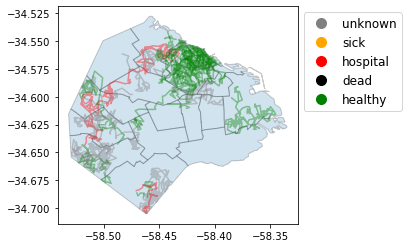

<Figure size 432x288 with 0 Axes>

In [35]:
model.sim.plot_sim(sim, patients = np.arange(10), color='known_status')
plt.savefig("sample_known_status.png")

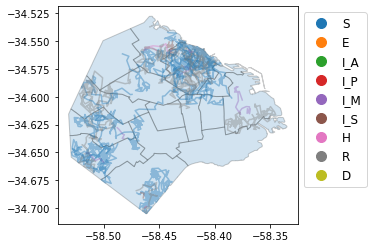

<Figure size 432x288 with 0 Axes>

In [36]:
model.sim.plot_sim(sim, patients = np.arange(10), color='state')
plt.savefig("sample_true_state.png")

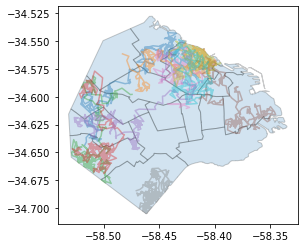

<Figure size 432x288 with 0 Axes>

In [37]:
model.sim.plot_sim(sim, patients = np.arange(10), color='patient')
plt.savefig("sample_patient_id.png")

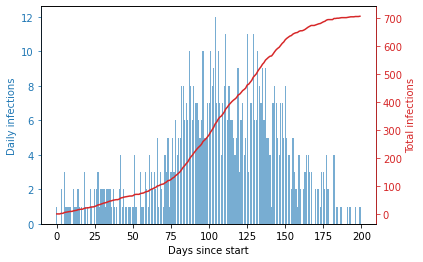

In [38]:
model.sim.plot_infections(sim)
plt.savefig("infection_rate.png")

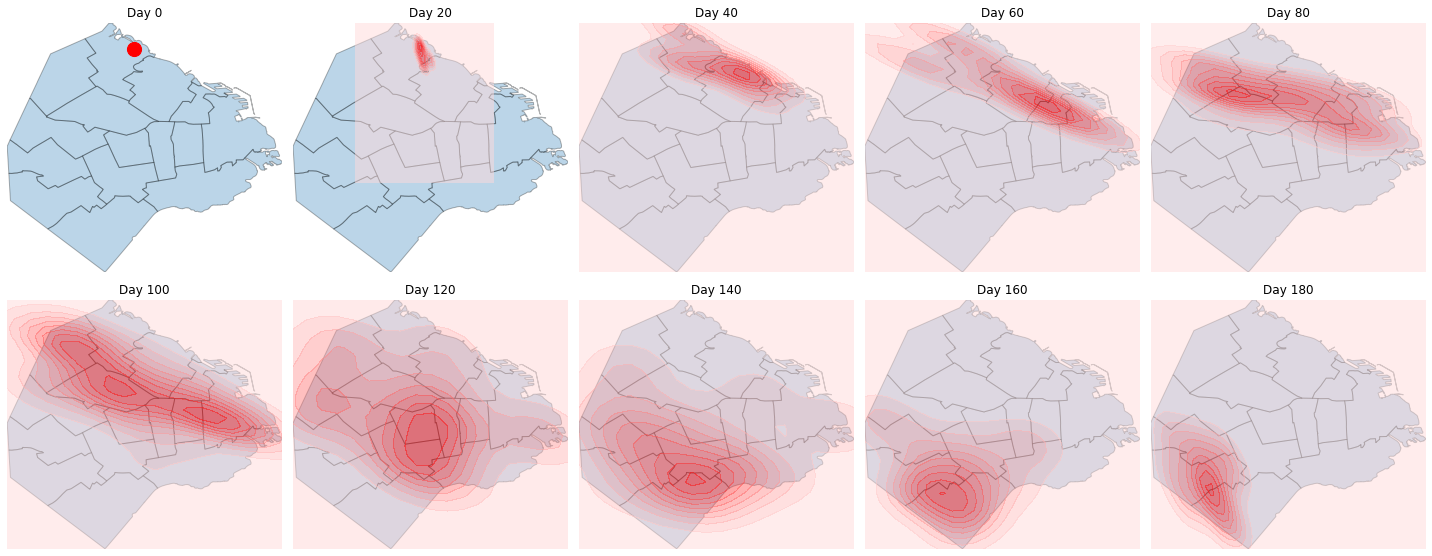

In [39]:
model.sim.plot_heatmap(sim)
plt.savefig("infectious_population_density.png")

In [15]:
sim['location'].head()

patient  date   latitude  longitude
0        0     0 -58.435613 -34.545653
1        0     1 -58.437731 -34.549600
2        0     2 -58.435019 -34.548340
3        0     3 -58.441275 -34.547083
4        0     4 -58.438393 -34.546874

In [16]:
sim['tests'].head()

patient date result
0       0    0  False
1      74    0  False
2     311    0  False
3     455    0  False
0       0    1  False

In [17]:
sim['hospital'].head()

patient  date
19      509     9
0         0    28
43      928    40
18      504    72
33      769    73

In [18]:
sim['deaths'].head()

patient  date
4      509    10
3      504    80
7      928    88
0      127   101
6      904   121

In [43]:
model.sim.io.save_pickle(sim)
model.sim.io.save_csv(sim)

## Disease spread modeling

For model specification, see the [README](../../README.md)

In [4]:
import pandas as pd
negative_tests = sim['tests'].loc[np.logical_not(sim['tests']['result'])][['patient', 'date']]
negative_tests['outcome'] = 'negative'
positive_tests = sim['tests'].loc[sim['tests']['result']][['patient', 'date']]
positive_tests['outcome'] = 'positive'
hospital = sim['hospital'].copy()
hospital['outcome'] = 'hospital'
deaths = sim['deaths'].copy()
deaths['outcome'] = 'dead'
outcomes = pd.concat([positive_tests, negative_tests, hospital, deaths])
outcomes

patient date   outcome
5      204    2  positive
9      807    2  positive
2      119    4  positive
8      455    4  positive
9      509    4  positive
..     ...  ...       ...
0      127  101      dead
6      904  121      dead
5      773  172      dead
2      226  175      dead
1      130  199      dead

[11557 rows x 3 columns]

In [5]:
from joblib import Parallel, delayed

def calculate_centrality(p, contacts):
    return np.sum([np.logical_or(contacts['patient1'] == p, contacts['patient2']==p)])

centrality = np.array(Parallel(10)(delayed(calculate_centrality)(p, sim['contacts'])
                       for p in sim['patients']['patient']))

In [6]:
centrality = pd.DataFrame({'centrality':centrality})
centrality.index.name = 'patient'

In [7]:
# set the initial state -- at present everyone is probably healthy
state = model.model.initial_state(sim)
state

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [8]:
# evaluate contacts each day and update the model
curr_date = 70
save_states = np.array([0, 1, 5, 10])
saved_states = {}
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

In [9]:
BETA0 = model.constants.beta0
output = pd.DataFrame(columns = ['id', 'date', 'state', 'scenario', 'prob'])

In [10]:
for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'id':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'moderate', 
            'prob':saved_states[i][:,j]
        })])

In [11]:
model.constants.beta0 = BETA0 * 0.8
state = model.model.initial_state(sim)
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'id':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'optimistic', 
            'prob':saved_states[i][:,j]
        })])

In [12]:
model.constants.beta0 = BETA0 * 1.2
state = model.model.initial_state(sim)
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'id':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'pessimistic', 
            'prob':saved_states[i][:,j]
        })])

In [13]:
sim['location'].to_csv("location.csv")
sim['contacts'].to_csv("contacts.csv")
outcomes.to_csv("outcomes.csv")
output.to_csv("output.csv")
centrality.to_csv("centrality.csv")

In [14]:
output.loc[(output['id'] == 989) & (output['date'] == 10) & (output['state'] == 'D')]

id date state     scenario      prob
989  989   10     D     moderate  0.004917
989  989   10     D   optimistic  0.003410
989  989   10     D  pessimistic  0.006235

In [68]:
# print the final model state
with np.printoptions(threshold=np.inf):
    print(state.round(3))

[[0.    0.    0.    0.    0.    0.    0.    0.8   0.2  ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.003 0.    0.01  0.969 0.018]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.166 0.667 0.167]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.014 0.789 0.197]
 [0.    0.    0.    0.    0.   

In [69]:
np.argmax(state, axis=1)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7,
       7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [70]:
sim['states'][:,-1]

array([7., 7., 7., 7., 0., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 0.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7.,
       5., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7.,
       7., 7., 7., 0., 0., 7., 7., 7., 0., 0., 7., 7., 7., 0., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 0., 0., 7., 7., 7., 0., 7., 7., 4., 7.,
       7., 0., 7., 7., 0., 7., 7., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 8., 0., 0., 8., 7., 7., 0., 7., 7.,
       0., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7., 7., 0., 7., 7., 0.,
       7., 7., 0., 7., 2., 7., 0., 7., 0., 0., 0., 7., 7., 0., 0., 7., 0.,
       0., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       0., 0., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       7., 7., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 0., 7., 7.